<a href="https://colab.research.google.com/github/nurriol2/forecasting/blob/ft-lstm/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import torch
import torch.nn as nn 

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"]=(16, 12)

In [47]:
#make use of GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("No GPU available, training on CPU")
device

GPU available


device(type='cuda')

In [48]:
#read appended bond data from github repo
bond_data = pd.read_csv("https://raw.githubusercontent.com/nurriol2/forecasting/master/datasets/old_school_bond_appended.csv", 
                        index_col="Unnamed: 0")
bond_data.head()

,Timestamps_close,Close,Timestamps_average,Average
0,2020/04/08,4134618,2020/04/08,4522980
1,2020/04/09,4009639,2020/04/09,4501601
2,2020/04/10,3903868,2020/04/10,4473252
3,2020/04/11,3853462,2020/04/11,4442300
4,2020/04/12,3941327,2020/04/12,4415261


In [49]:
bond_data.shape

(200, 4)

*Number of samples per set*  
170 - train    
20 - valid  
10 - test  

**So the task will be to predict bond price for the next 10 days given 170 training samples and 20 validation samples**

In [50]:
all_data = bond_data["Close"].values.astype(float)

In [51]:
training_data = all_data[:170]
validation_data = all_data[171:191]
test_data = all_data[-10:]

In [52]:
#normalize the data sets
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
training_data = scaler.fit_transform(training_data.reshape(-1, 1))
validation_data = scaler.fit_transform(validation_data.reshape(-1, 1))

In [53]:
training_data[:5], training_data[-5:]

(array([[-0.21257071],
        [-0.34051259],
        [-0.4487911 ],
        [-0.50039208],
        [-0.41044406]]), array([[0.81887142],
        [0.81664793],
        [0.88317558],
        [0.93785894],
        [0.92705166]]))

In [54]:
#sequence length
train_window = 10

def create_sequences(input_data, tw):
    #tw day sequence formed from interval slices of input_data
    xs = []
    ys = []
    for i in range(len(input_data)-tw):
        #tw sequence
        x = input_data[i:i+tw]
        xs.append(x)
        #corresponding label (predicted price)
        label = input_data[i+tw]
        ys.append(label)

    return np.array(xs), np.array(ys)

X_train, y_train = create_sequences(training_data, train_window)
X_valid, y_valid = create_sequences(validation_data, train_window)

In [55]:
len(X_train)

160

In [56]:
#convert X and y to tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_valid = torch.from_numpy(X_valid).float()
y_valid = torch.from_numpy(y_valid).float()

In [57]:
#num sequenecs, len sequences, 1
X_train.shape

torch.Size([160, 10, 1])

In [58]:
y_train.shape

torch.Size([160, 1])

In [59]:
class PricePredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(PricePredictor, self).__init__()

        self.n_features = n_features
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            dropout=0.5
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

        return 

    def init_hidden(self):
        return (torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
         torch.zeros(self.n_layers, self.seq_len, self.n_hidden))

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        
        y_pred = self.linear(last_time_step)
        
        return y_pred

In [60]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None):
    
    loss_fn = torch.nn.MSELoss(reduction="sum")

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

    num_epochs = 60

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        #model.zero_grad()

        model.hidden = model.init_hidden()

        #why do we do this when train_data is passed?
        y_pred = model(X_train)

        loss = loss_fn(y_pred.float(), y_train)

        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_valid)
                test_loss = loss_fn(y_test_pred, y_valid)
            test_hist[epoch] = test_loss.item()

            if epoch%10==0:
                print(f"Epoch: {epoch} Train Loss: {loss.item()} Test Loss: {test_loss.item()}")
        
        elif epoch%10==10:
            print(f"Epoch: {epoch} Train Loss: {loss.item()}")
        
        train_hist[epoch] = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return model.eval(), train_hist, test_hist

In [61]:
model = PricePredictor(n_features=1, n_hidden=512, seq_len=train_window, n_layers=2)

model, train_hist, test_hist = train_model(model=model, 
                                           train_data=X_train,
                                           train_labels=y_train,
                                           test_data=X_valid,
                                           test_labels=y_valid)

Epoch: 0 Train Loss: 52.935028076171875 Test Loss: 2.6211013793945312
Epoch: 10 Train Loss: 54.775386810302734 Test Loss: 2.2850728034973145
Epoch: 20 Train Loss: 60.389259338378906 Test Loss: 6.529139995574951
Epoch: 30 Train Loss: 55.011444091796875 Test Loss: 5.284668922424316
Epoch: 40 Train Loss: 51.37872314453125 Test Loss: 3.4753401279449463
Epoch: 50 Train Loss: 51.910945892333984 Test Loss: 2.8830413818359375


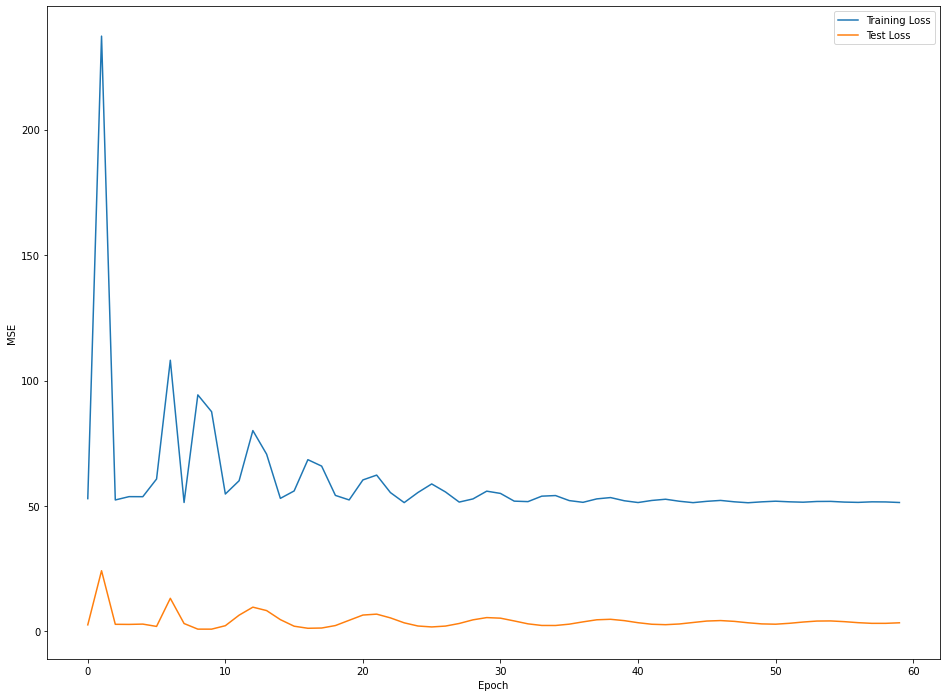

In [62]:
plt.plot(train_hist, label="Training Loss")
plt.plot(test_hist, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [63]:
with torch.no_grad():
    test_seq = X_valid[:1]
    preds = []
    for _ in range(len(X_valid)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, model.seq_len, 1).float()

In [64]:
true_price = scaler.inverse_transform(np.expand_dims(y_valid.flatten().numpy(), axis=0)).flatten()

In [65]:
predicted_price = scaler.inverse_transform(np.expand_dims(preds, axis=0)).flatten()

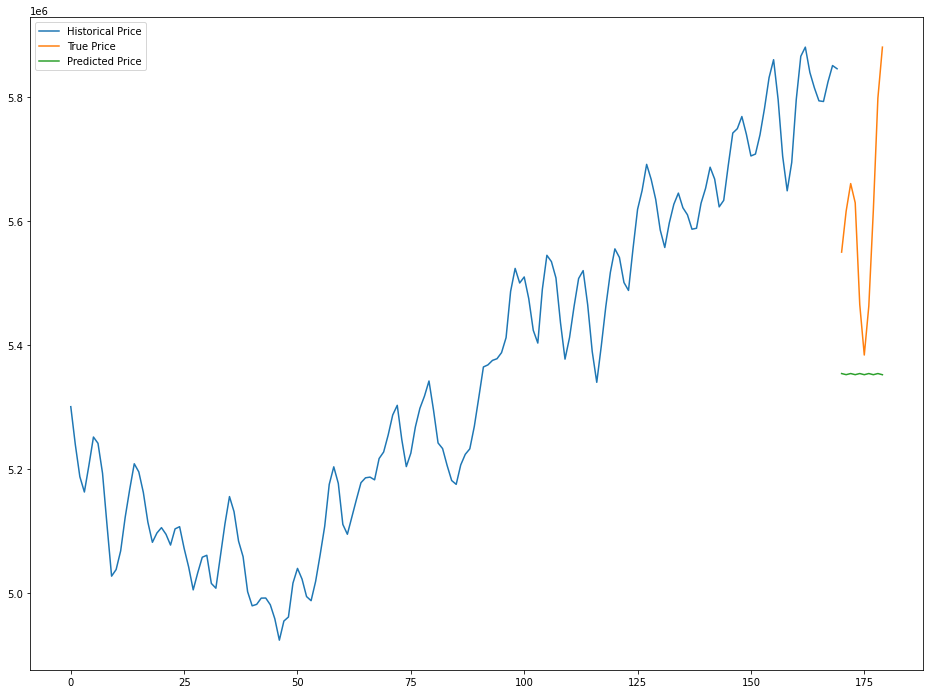

In [70]:
plt.plot(scaler.inverse_transform(training_data).flatten()[:len(training_data)], label="Historical Price")
plt.plot(np.arange(len(training_data), len(training_data)+len(true_price)), true_price, label="True Price")
plt.plot(np.arange(len(training_data), len(training_data)+len(predicted_price)), predicted_price, label="Predicted Price")

plt.legend()
plt.show()